# **IMPORTING NECESSARY LIBRARIES**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.applications import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

# **LOADING AND UNZIPPING THE DATASET**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-12-04 21:28:09--  https://docs.google.com/uc?export=download&confirm=hTG2&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 172.217.164.174, 2607:f8b0:4004:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.164.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-bo-docs.googleusercontent.com/docs/securesc/9tkbqu6mbua3nd50nes2j3s9304rsvf7/ags0501hojvo4t9vegqk1df4l3lhch16/1607117250000/14211000813324722452/12015582030500939810Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-12-04 21:28:09--  https://doc-0k-bo-docs.googleusercontent.com/docs/securesc/9tkbqu6mbua3nd50nes2j3s9304rsvf7/ags0501hojvo4t9vegqk1df4l3lhch16/1607117250000/14211000813324722452/12015582030500939810Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-0k-bo-docs.googleusercontent.com (doc-0k-bo-docs.googleusercontent.com)... 172.217.13.65, 2607:f8b0:4004:808::2001
Connecting to doc-

In [ ]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (676).jpg  
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottle

# **SPECIFIYING PATHS TO DIRECTORY**

In [ ]:
from glob import glob
base_path = '/content/split_dataset'
folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/boots', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/knives', '/content/split_dataset/train/syringes', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/bottles', '/content/split_dataset/train/bullet_shells']


In [ ]:
IMAGE_SIZE = [299, 299]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED InceptionV3**

In [ ]:
Inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in Inception.layers:
  layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
x = Flatten()(Inception.output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE VGG16 MODEL**

In [ ]:
model_Inception = Model(inputs=Inception.input, outputs=prediction)
model_Inception.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
opt = Adam(lr=0.0006)

model_Inception.compile(
  loss='categorical_crossentropy',
  optimizer= opt,
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [ ]:
history_Inception = model_Inception.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=150,
  validation_steps=32
  )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
 13/150 [=>............................] - ETA: 1:34 - loss: 2.2705 - accuracy: 0.1707

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


150/150 [==============================] - 124s 829ms/step - loss: 1.4593 - accuracy: 0.4650 - val_loss: 0.5502 - val_accuracy: 0.8203
Epoch 2/50
150/150 [==============================] - 122s 812ms/step - loss: 0.6356 - accuracy: 0.7791 - val_loss: 0.3094 - val_accuracy: 0.8965
Epoch 3/50
150/150 [==============================] - 122s 814ms/step - loss: 0.4479 - accuracy: 0.8552 - val_loss: 0.2039 - val_accuracy: 0.9443
Epoch 4/50
150/150 [==============================] - 122s 814ms/step - loss: 0.3857 - accuracy: 0.8792 - val_loss: 0.2424 - val_accuracy: 0.9277
Epoch 5/50
150/150 [==============================] - 122s 814ms/step - loss: 0.3538 - accuracy: 0.8908 - val_loss: 0.1474 - val_accuracy: 0.9541
Epoch 6/50
150/150 [==============================] - 121s 809ms/step - loss: 0.2978 - accuracy: 0.9131 - val_loss: 0.1164 - val_accuracy: 0.9619
Epoch 7/50
150/150 [==============================] - 121s 808ms/step - loss: 0.2736 - accuracy: 0.9183 - val_loss: 0.1660 - val_accura

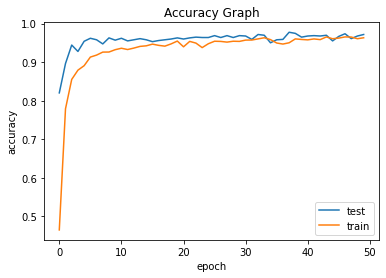

In [ ]:
plt.plot(history_Inception.history['val_accuracy'])
plt.plot(history_Inception.history['accuracy'])
plt.title('Accuracy Graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['test', 'train'], loc='lower right')
plt.show()

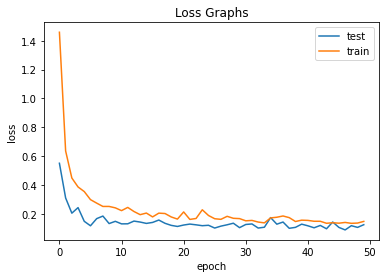

In [ ]:
plt.plot(history_Inception.history['val_loss'])
plt.plot(history_Inception.history['loss'])
plt.title('Loss Graphs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['test', 'train'], loc='upper right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_Inception.save('/content/gdrive/My Drive/Model/inception.h5')